# Recurrent Neural Networks

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('C:/Users/aloke/Downloads/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [6]:
from pandas.tseries.offsets import MonthEnd

In [7]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


<AxesSubplot:xlabel='Adjustments'>

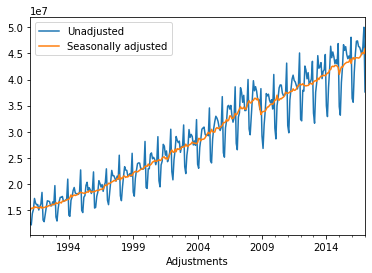

In [8]:
df.plot()

In [9]:
split_date = pd.Timestamp('01-01-2011')

In [10]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

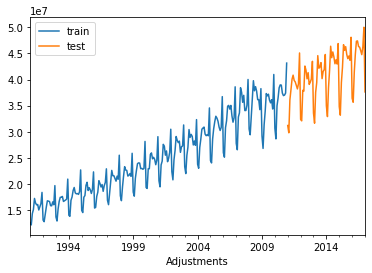

In [11]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [12]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [13]:
train_sc[:4]

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795]])

In [14]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

## Fully connected predictor

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [17]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [18]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
120/120 [==============================] - 0s 370us/step - loss: 0.1341
Epoch 2/200
120/120 [==============================] - 0s 361us/step - loss: 0.0322
Epoch 3/200
120/120 [==============================] - 0s 361us/step - loss: 0.0250
Epoch 4/200
120/120 [==============================] - 0s 361us/step - loss: 0.0202
Epoch 5/200
120/120 [==============================] - 0s 361us/step - loss: 0.0167
Epoch 6/200
120/120 [==============================] - 0s 371us/step - loss: 0.0140
Epoch 7/200
120/120 [==============================] - 0s 361us/step - loss: 0.0124
Epoch 8/200
120/120 [==============================] - 0s 361us/step - loss: 0.0113
Epoch 9/200
120/120 [==============================] - 0s 370us/step - loss: 0.0107
Epoch 10/200
120/120 [==============================] - 0s 353us/step - loss: 0.0103
Epoch 11/200
120/120 [==============================] - 0s 370us/step - loss: 0.0102
Epoch 12/200
120/120 [==============================] - 0s 361us/step - lo

In [19]:
y_pred = model.predict(X_test)

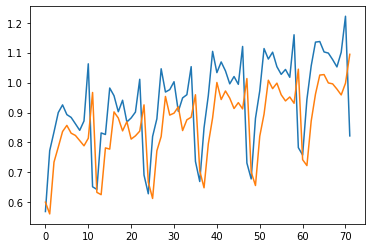

In [20]:
plt.plot(y_test)
plt.plot(y_pred)

## Recurrent predictor

In [21]:
from tensorflow.keras.layers import LSTM

In [22]:
X_train.shape

(239, 1)

In [23]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape

(239, 1, 1)

In [24]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [25]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 1s 626us/step - loss: 0.0891
Epoch 2/100
239/239 [==============================] - 0s 613us/step - loss: 0.0300
Epoch 3/100
239/239 [==============================] - 0s 639us/step - loss: 0.0235
Epoch 4/100
239/239 [==============================] - 0s 622us/step - loss: 0.0181
Epoch 5/100
239/239 [==============================] - 0s 622us/step - loss: 0.0145
Epoch 6/100
239/239 [==============================] - 0s 761us/step - loss: 0.0121
Epoch 7/100
239/239 [==============================] - 0s 655us/step - loss: 0.0110
Epoch 8/100
239/239 [==============================] - 0s 626us/step - loss: 0.0106
Epoch 9/100
239/239 [==============================] - 0s 626us/step - loss: 0.0104
Epoch 10/100
239/239 [==============================] - 0s 668us/step - loss: 0.0102
Epoch 11/100
239/239 [==============================] - 0s 630us/step - loss: 0.0103
Epoch 00011: early stopping


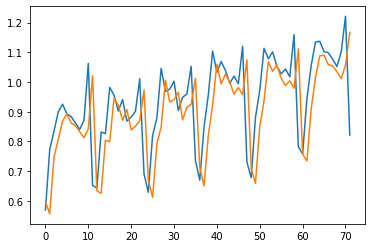

In [27]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Windows

In [28]:
train_sc.shape

(240, 1)

In [29]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [30]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [31]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [32]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [33]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [34]:
X_train.shape

(228, 12)

In [35]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

## Fully Connected on Windows

In [36]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 [==============================] - 0s 335us/step - loss: 0.0457
Epoch 2/200
228/228 [==============================] - 0s 335us/step - loss: 0.0067
Epoch 3/200
228/228 [==============================] - 0s 352us/step - loss: 0.0057
Epoch 4/200
228/228 [==============================] - 0s 361us/step - loss: 0.0050
Epoch 5/200
228/228 [==============================] - 0s 344us/step - loss: 0.0047
Epoch 6/200
228/228 [==============================] - 0s 361us/step - loss: 0.0041
Epoch 7/200
228/228 [==============================] - 0s 357us/step - loss: 0.0038
Epoch 8/200
228/228 [==============================] - 0s 379us/step - loss: 0.0032
Epoch 9/200
228/228 [==============================] - 0s 383us/step - loss: 0.0027
Epoch 10/200
228/228 [==============================] - 0s 379us/step - loss: 0.0024
Epoch 11/200
228/228 [==============================] - 0s 383us/step - loss: 0.0022
Epoch 12/200
228/228 [==============================] - 0s 370us/step - lo

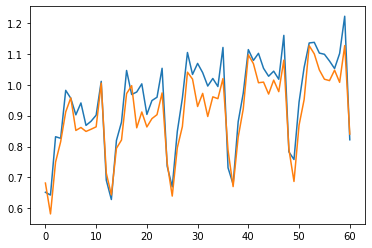

In [38]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

## LSTM on Windows

In [39]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [40]:
X_train_t.shape

(228, 1, 12)

In [41]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 456       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 1s 678us/step - loss: 0.0440
Epoch 2/100
228/228 [==============================] - 0s 630us/step - loss: 0.0093
Epoch 3/100
228/228 [==============================] - 0s 665us/step - loss: 0.0082
Epoch 4/100
228/228 [==============================] - 0s 661us/step - loss: 0.0068
Epoch 5/100
228/228 [==============================] - 0s 652us/step - loss: 0.0063
Epoch 6/100
228/228 [==============================] - 0s 626us/step - loss: 0.0051
Epoch 7/100
228/228 [==============================] - 0s 714us/step - loss: 0.0044
Epoch 8/100
228/228 [==============================] - 0s 678us/step - loss: 0.0036
Epoch 9/100
228/228 [==============================] - 0s 626us/step - loss: 0.0030
Epoch 10/100
228/228 [==============================] - 0s 630us/step - loss: 0.0028
Epoch 11/100
228/228 [==============================] - 0s 621us/step - loss: 0.0024
Epoch 12/100
228/228 [==============================] - 0s 612us/step - lo

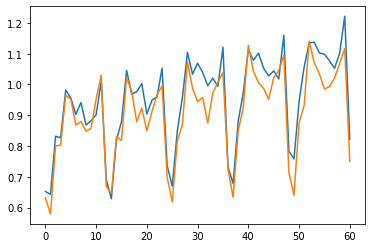

In [44]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 1

In [45]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [46]:
X_train_t.shape

(228, 12, 1)

In [47]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(12, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=1)

Epoch 1/600
8/8 [==============================] - 1s 3ms/step - loss: 0.0057
Epoch 2/600
8/8 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3/600
8/8 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 4/600
8/8 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 5/600
8/8 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 6/600
8/8 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 7/600
8/8 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 8/600
8/8 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 9/600
8/8 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 10/600
8/8 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 11/600
8/8 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 12/600
8/8 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 13/600
8/8 [==============================] - 0s 3ms/st

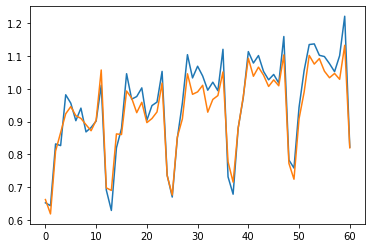

In [52]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 2

In [61]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [55]:
(X_train, y_train), (X_test, y_test) = mnist.load_data('/tmp/mnist.npz')

In [62]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [63]:
X_train_t = X_train.reshape(X_train.shape[0], -1, 1)
X_test_t = X_test.reshape(X_test.shape[0], -1, 1)

In [64]:
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 10)
(10000, 10)


In [65]:
K.clear_session()
model = Sequential()

model.add(LSTM(32, input_shape=X_train.shape[1:]))

model.add(Dense(10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 18984     
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 18,991
Trainable params: 18,991
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.fit(X_train, y_train_cat,
          batch_size=32,
          epochs=100,
          validation_split=0.3,
          shuffle=True,
          verbose=2,
          )

Epoch 1/100
1313/1313 - 7s - loss: 0.8854 - accuracy: 0.7180 - val_loss: 0.4307 - val_accuracy: 0.8699
Epoch 2/100
1313/1313 - 6s - loss: 0.3283 - accuracy: 0.9008 - val_loss: 0.3088 - val_accuracy: 0.9091
Epoch 3/100
1313/1313 - 6s - loss: 0.2211 - accuracy: 0.9357 - val_loss: 0.2121 - val_accuracy: 0.9387
Epoch 4/100
1313/1313 - 6s - loss: 0.1762 - accuracy: 0.9492 - val_loss: 0.2339 - val_accuracy: 0.9334
Epoch 5/100
1313/1313 - 6s - loss: 0.1480 - accuracy: 0.9572 - val_loss: 0.1477 - val_accuracy: 0.9581
Epoch 6/100
1313/1313 - 6s - loss: 0.1261 - accuracy: 0.9628 - val_loss: 0.1369 - val_accuracy: 0.9594
Epoch 7/100
1313/1313 - 6s - loss: 0.1113 - accuracy: 0.9670 - val_loss: 0.1341 - val_accuracy: 0.9618
Epoch 8/100
1313/1313 - 6s - loss: 0.1000 - accuracy: 0.9696 - val_loss: 0.1104 - val_accuracy: 0.9672
Epoch 9/100
1313/1313 - 6s - loss: 0.0907 - accuracy: 0.9725 - val_loss: 0.1100 - val_accuracy: 0.9671
Epoch 10/100
1313/1313 - 6s - loss: 0.0832 - accuracy: 0.9749 - val_loss:

In [67]:
model.evaluate(X_test, y_test_cat)

313/313 [==============================] - 0s 1ms/step - loss: 0.1190 - accuracy: 0.9827


[0.1189606562256813, 0.982699990272522]